# **Setup**

In [1]:
!pip install tensorflow==2.12.0

In [2]:
!pip install tensorflow-addons

In [3]:
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import layers


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

# **Configuration**


In [4]:
class Config:
    # Origin image size
    input_size = 28
    # Input shape of image
    input_shape = [input_size, input_size, 1]
    # Learning rate of the Model
    learning_rate = 0.001
    # Weight decay rate of the Model
    weight_decay = 0.0001
    # Batch size of the Model batch_size = 256
    batch_size = 256
    num_classes = 10
    num_epochs = 30
    image_size = 72
    patch_size = 6
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [
        projection_dim * 2,
        projection_dim
    ]
    transformer_layers = 8
    mlp_head_units = [2048, 1024]

# **Helpers**


**Sample Images**

In [5]:
def sample_images(images, row_count, column_count):
    fig, axs = plt.subplots(row_count, column_count, figsize=(10,10))
    for i in range(row_count):
        for j in range(column_count):
            axs[i,j].imshow(images[i * column_count + j])
            axs[i,j].axis('off')
    plt.show()

# **Import and preprcess dataset**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
train = pd.read_csv("/content/drive/MyDrive/fashionMINST/fashion-mnist_train.csv")
test = pd.read_csv("/content/drive/MyDrive/fashionMINST/fashion-mnist_test.csv")
train_labels = train.pop("label")
test_labels = test.pop("label")

In [8]:
train = np.array(train).reshape((-1, Config.input_size, Config.input_size, 1))
test = np.array(test).reshape((-1, Config.input_size, Config.input_size, 1))

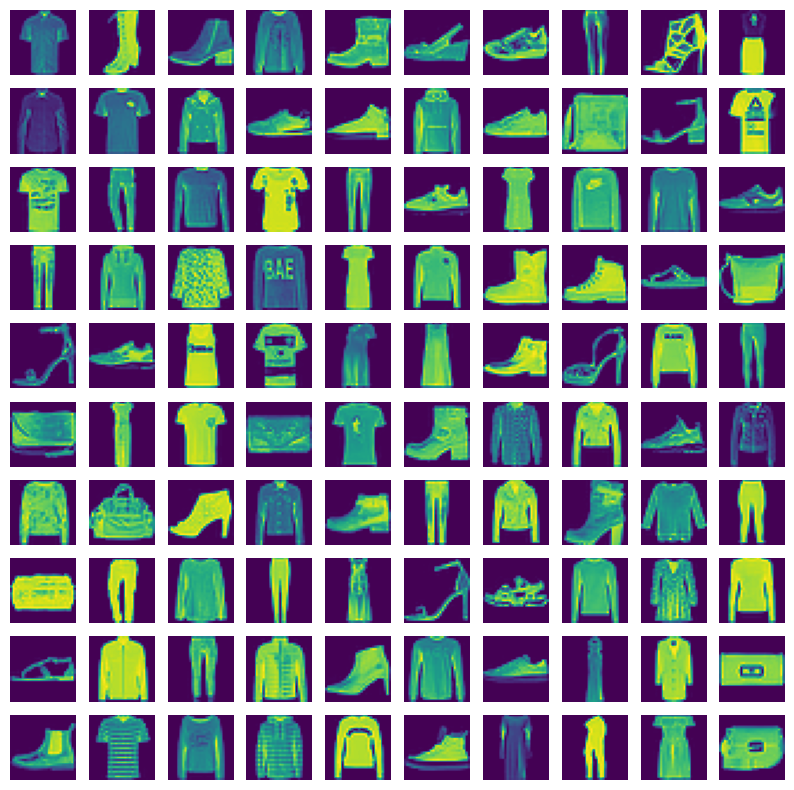

In [9]:
indices = np.random.choice(train.shape[0], 100)
sample_images(train[indices].squeeze(), 10, 10)

# **Model Development**

**Data Augmentation**


In [10]:
augmentation_layer = tf.keras.Sequential([
    keras.layers.Input(Config.input_shape),
    keras.layers.experimental.preprocessing.Normalization(),
    keras.layers.experimental.preprocessing.Resizing(Config.image_size, Config.image_size),
    keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
    keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
])

**MLP**

In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

**Patches Creation Layer**

This Layer can convert image to N x N Grid.



In [12]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

(256, 72, 72, 1)
Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 36


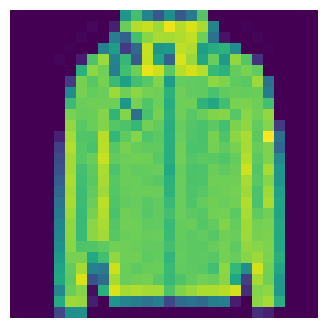

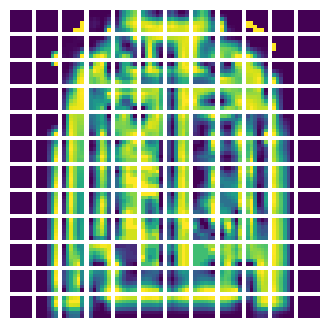

In [13]:
plt.figure(figsize=(4, 4))
start_index = np.random.choice(train.shape[0] // 2)
image = train[start_index: start_index + Config.batch_size]
plt.imshow(np.squeeze(image[0]).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor(image), size=(Config.image_size, Config.image_size)
)
print(resized_image.shape)
patches = Patches(Config.patch_size)(resized_image)
print(f"Image size: {Config.image_size} X {Config.image_size}")
print(f"Patch size: {Config.patch_size} X {Config.patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (Config.patch_size, Config.patch_size))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

**Patch Encoder Layer**

In [14]:
class PatchEncoder(layers.Layer):

    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

**Build the Model**

In [15]:
def create_vision_transformer():
    # Inputs
    inputs = layers.Input(shape=Config.input_shape)
    # Data Augmentation
    augmented = augmentation_layer(inputs)
    # Patches
    patches = Patches(Config.patch_size)(augmented)
    encoder_patches = PatchEncoder(Config.num_patches, Config.projection_dim)(patches)

    for _ in range(Config.transformer_layers):
        # Layer Normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
        # Multi-Head Attention Layer
        attention_output = layers.MultiHeadAttention(
            num_heads=Config.num_heads,
            key_dim=Config.projection_dim,
            dropout=0.1
        )(x1, x1)
        # Skip Connnection 1
        x2 = attention_output + encoder_patches

        # Layer Normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = mlp(x3, hidden_units=Config.transformer_units, dropout_rate=0.1)

        # Skip Connnection 2
        encoder_patches = x3 + x2

    representation = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=Config.mlp_head_units, dropout_rate=0.5)

    outputs = layers.Dense(Config.num_classes)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [16]:
keras.backend.clear_session()
vit_classifier = create_vision_transformer()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 72, 72, 1)    3           ['input_1[0][0]']                
                                                                                                  
 patches (Patches)              (None, None, 36)     0           ['sequential[0][0]']             
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      11584       ['patches[0][0]']                
                                                                                              

**Training**

In [17]:
optimizer = tfa.optimizers.AdamW(
    learning_rate=Config.learning_rate,
    weight_decay=Config.weight_decay
)
vit_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"]
)
checkpoint_path = "model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)